In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(1, "../..")
from simulations import van_der_pol_oscillator
from itertools import product
from prototype_nn import Splitting, predictions, tensor_flatten
import matplotlib.pyplot as plt
import torch
%run ../utilities.ipynb

## Training set : Simulations

## Dataframes

This is the simulations we use for training. The initial parameters x,y are within set [1,2,3,45]

In [2]:
training = pd.DataFrame(data = pd.read_csv("../../data/train/van.csv"))
training.head()

,time,x,y,initial_x,initial_y
0,0.000,1.000000,1.000000,1,1
1,0.001,1.000999,0.998999,1,1
2,0.002,1.001998,0.997996,1,1
3,0.003,1.002995,0.996991,1,1
4,0.004,1.003992,0.995984,1,1


In [3]:
len(training)

321600

This is to zip the initial parameters columns together

In [4]:
training["initial_parameters"] = list(zip(training.initial_x, training.initial_y))
training.head()

,time,x,y,initial_x,initial_y,initial_parameters
0,0.000,1.000000,1.000000,1,1,"(1, 1)"
1,0.001,1.000999,0.998999,1,1,"(1, 1)"
2,0.002,1.001998,0.997996,1,1,"(1, 1)"
3,0.003,1.002995,0.996991,1,1,"(1, 1)"
4,0.004,1.003992,0.995984,1,1,"(1, 1)"


This allows you to get the simulations where the initial parameters are x = 1, y = 1

In [5]:
initial_x1y1 = training[training["initial_parameters"] == (1,1)]

This would plots the graphs of inital parameters x = 1 , y = 1

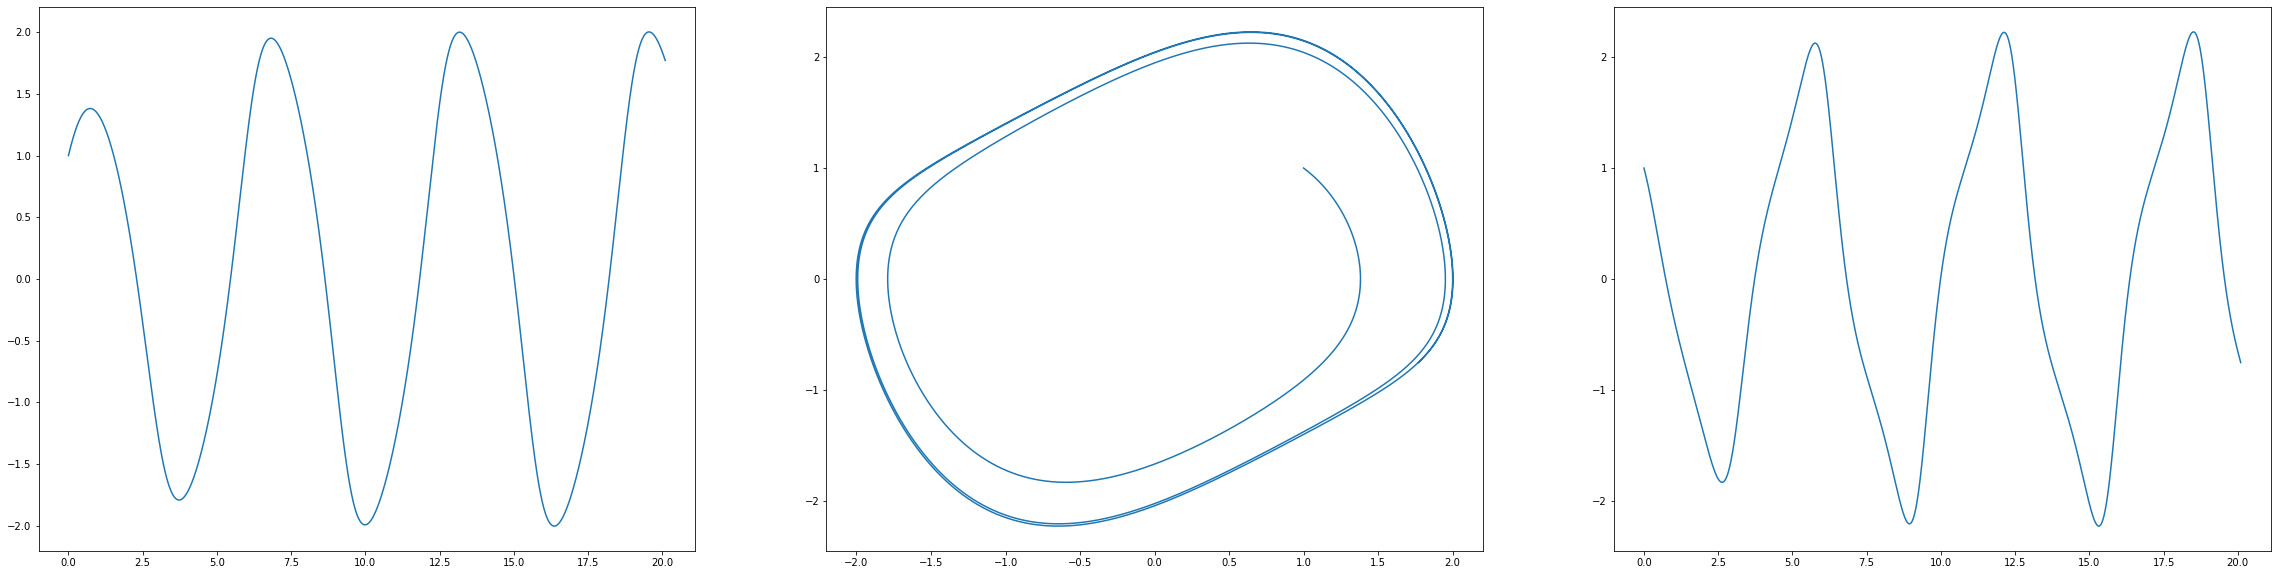

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(40,10))
ax[0].plot(initial_x1y1[["time"]], initial_x1y1[["x"]])
ax[1].plot(initial_x1y1[["x"]], initial_x1y1[["y"]])
ax[2].plot(initial_x1y1[["time"]],initial_x1y1[["y"]])

<AxesSubplot:xlabel='time', ylabel='x'>

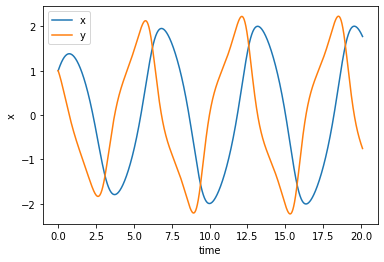

In [7]:
fig, ax = plt.subplots()
sns.lineplot(data = initial_x1y1, x = "time", y = "x", ax = ax,label = "x")
sns.lineplot(data = initial_x1y1, x = "time", y = "y", ax=ax, label = "y")

## Cross validation

This is applying cross validation to our training data

In [7]:
# lr = 0.0001, bs = 15, ts = 15, epoch = 50
kfold = Splitting([0,3,4], [1,2], num_epoches = 20, batch_size = 32, lr= 0.00001)

In [63]:
evaluate = kfold.cross_validation_evaluate(training, 5)

------------- Fold 0 -------------
TEST: 0 TRAIN: [1, 2, 3, 4]
Epoch: 0  Train Loss: 1.4208863973617554 
Epoch: 1  Train Loss: 1.348236083984375 
Epoch: 2  Train Loss: 1.3198518753051758 
Epoch: 3  Train Loss: 1.247514009475708 
Epoch: 4  Train Loss: 0.5578887462615967 
Epoch: 5  Train Loss: 0.6039469838142395 
Epoch: 6  Train Loss: 0.5462912917137146 
Epoch: 7  Train Loss: 0.792505145072937 
Epoch: 8  Train Loss: 0.34403327107429504 
Epoch: 9  Train Loss: 0.30851471424102783 
Epoch: 10  Train Loss: 0.11517158895730972 
Epoch: 11  Train Loss: 0.2258167266845703 
Epoch: 12  Train Loss: 0.05869479104876518 
Epoch: 13  Train Loss: 0.03177453577518463 
Epoch: 14  Train Loss: 0.030222054570913315 
Epoch: 15  Train Loss: 0.006974079646170139 
Epoch: 16  Train Loss: 0.020275916904211044 
Epoch: 17  Train Loss: 0.02632710710167885 
Epoch: 18  Train Loss: 0.01822817511856556 
Epoch: 19  Train Loss: 0.006948888301849365 
------------- Fold 1 -------------
TEST: 1 TRAIN: [0, 2, 3, 4]
Epoch: 0  Tr

This is the evaluatons from the cross validation

In [64]:
evaluate

[tensor(0.0161, grad_fn=<MseLossBackward>),
 tensor(0.0079, grad_fn=<MseLossBackward>),
 tensor(0.0067, grad_fn=<MseLossBackward>),
 tensor(0.0286, grad_fn=<MseLossBackward>),
 tensor(0.0145, grad_fn=<MseLossBackward>)]

Measures the average of the evaluations

In [65]:
average_loss = 0
for x in evaluate:
    average_loss += x.item()
average_loss/len(evaluate)

0.014756467379629611

## Training Data : Predictions

This loads the predictions of the training data.

In [16]:
training_preds = pd.DataFrame(data = pd.read_csv("../../data/preds/train/van.csv"))
training_preds.head()

,time,initial_x,initial_y,x,y
0,0.000,1,1,0.878540,1.075928
1,0.001,1,1,0.880194,1.073958
2,0.002,1,1,0.881844,1.071989
3,0.003,1,1,0.883496,1.070020
4,0.004,1,1,0.885149,1.068051


This manipulate the "training_preds" dataframes (we drop columns, and rename some columns) to be later used for plotting graphs

In [17]:
training_preds = training_preds.rename(columns={
                                            'x' : 'x_preds',
                                            'y' : 'y_preds'})

This shows the first 4 rows of the training predictions.

In [18]:
training_preds.head()

,time,initial_x,initial_y,x_preds,y_preds
0,0.000,1,1,0.878540,1.075928
1,0.001,1,1,0.880194,1.073958
2,0.002,1,1,0.881844,1.071989
3,0.003,1,1,0.883496,1.070020
4,0.004,1,1,0.885149,1.068051


This combines the training data and predictions dataframe together

In [19]:
training_and_predictions = pd.merge(training, training_preds, right_on = ["initial_x", "initial_y", "time"],
                                    left_on = ["initial_x", "initial_y", "time"])

This is the first 5 rows within the dataframes 

In [20]:
training_and_predictions.head()

,time,x,y,initial_x,initial_y,initial_parameters,x_preds,y_preds
0,0.000,1.000000,1.000000,1,1,"(1, 1)",0.878540,1.075928
1,0.001,1.000999,0.998999,1,1,"(1, 1)",0.880194,1.073958
2,0.002,1.001998,0.997996,1,1,"(1, 1)",0.881844,1.071989
3,0.003,1.002995,0.996991,1,1,"(1, 1)",0.883496,1.070020
4,0.004,1.003992,0.995984,1,1,"(1, 1)",0.885149,1.068051


This function is defined to be later used for plotting graphs

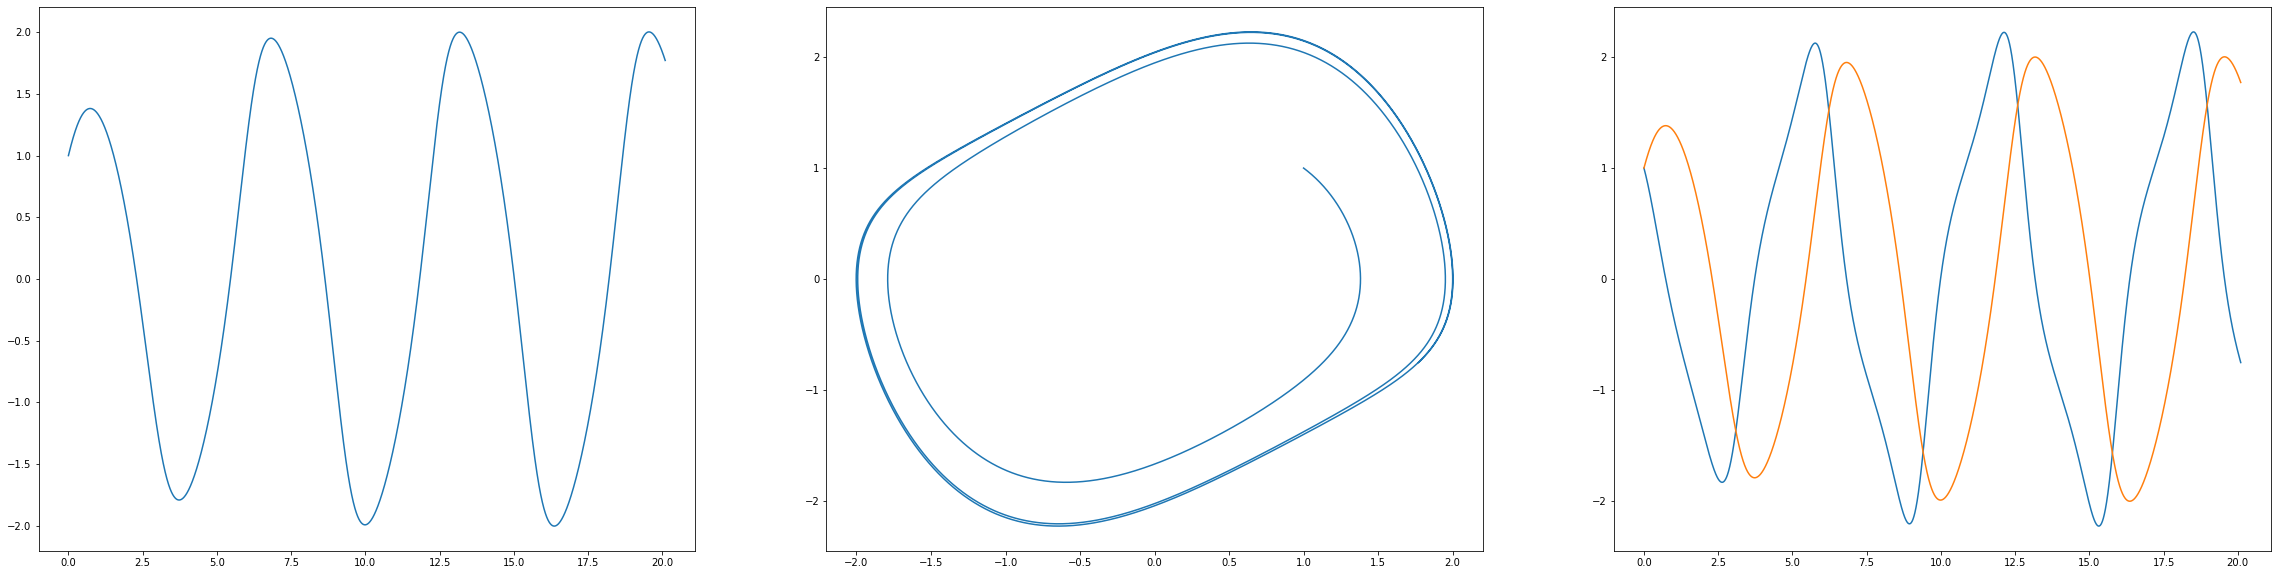

In [31]:
initial_x1y1_train = training_and_predictions[training_and_predictions["initial_parameters"] == (1,1)]
fig, ax = plt.subplots(ncols=3, figsize=(40,10))
ax[0].plot(initial_x1y1_train[["time"]], initial_x1y1_train[["x"]])
ax[0].plot(initial_x1y1_train[["time"]], initial_x1y1_train[["x"]])
ax[1].plot(initial_x1y1_train[["x"]], initial_x1y1_train[["y"]])
ax[2].plot(initial_x1y1_train[["time"]],initial_x1y1_train[["y"]])

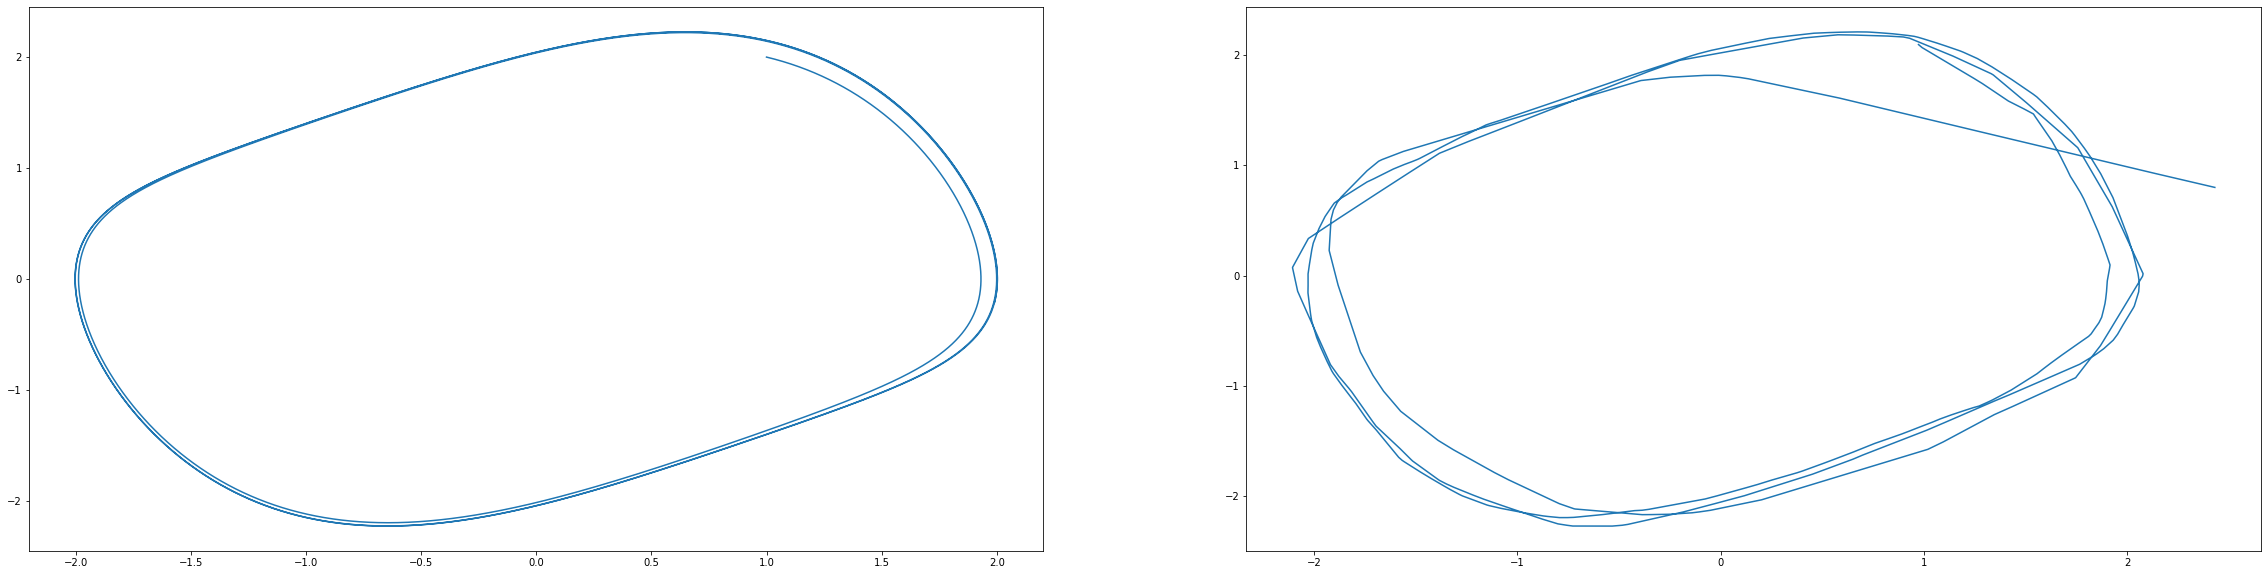

In [53]:
fig, ax = plt.subplots(ncols = 2, figsize=(40,10))
ax[0].plot(initial_x1y1_train[["x"]], initial_x1y1_train[["y"]])
ax[1].plot(initial_x1y1_train[["x_preds"]], initial_x1y1_train[["y_preds"]])


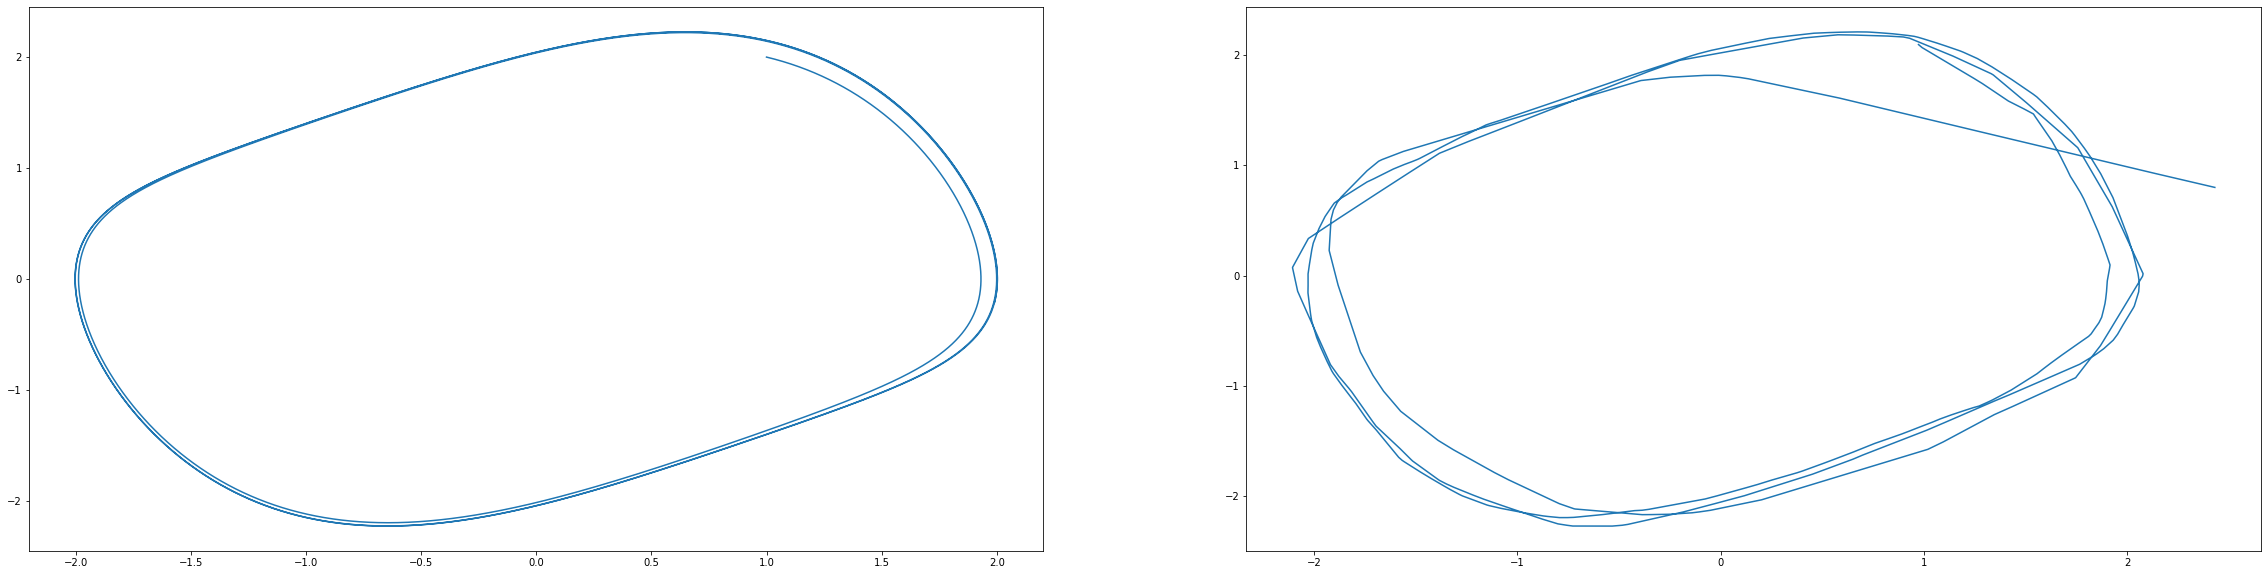

In [47]:
initial_x1y1_train = training_and_predictions[training_and_predictions["initial_parameters"] == (1,2)]
fig, ax = plt.subplots(ncols = 2, figsize=(40,10))
ax[0].plot(initial_x1y1_train[["x"]], initial_x1y1_train[["y"]])
ax[1].plot(initial_x1y1_train[["x_preds"]], initial_x1y1_train[["y_preds"]])

In [21]:
def hue(df, hue):
    for var in hue:
        columns = list(df.columns)
        columns.remove(var)
        columns.remove("{}_{}".format(var,"preds"))
        df = df.melt(columns, var_name=var, value_name = f"{var}value")
    return df

## Graphs

Looking at training simulations compared to the predictions. This produces a high results

In [36]:
def plot(x, y,**kwargs):
    plt.plot(x,y)

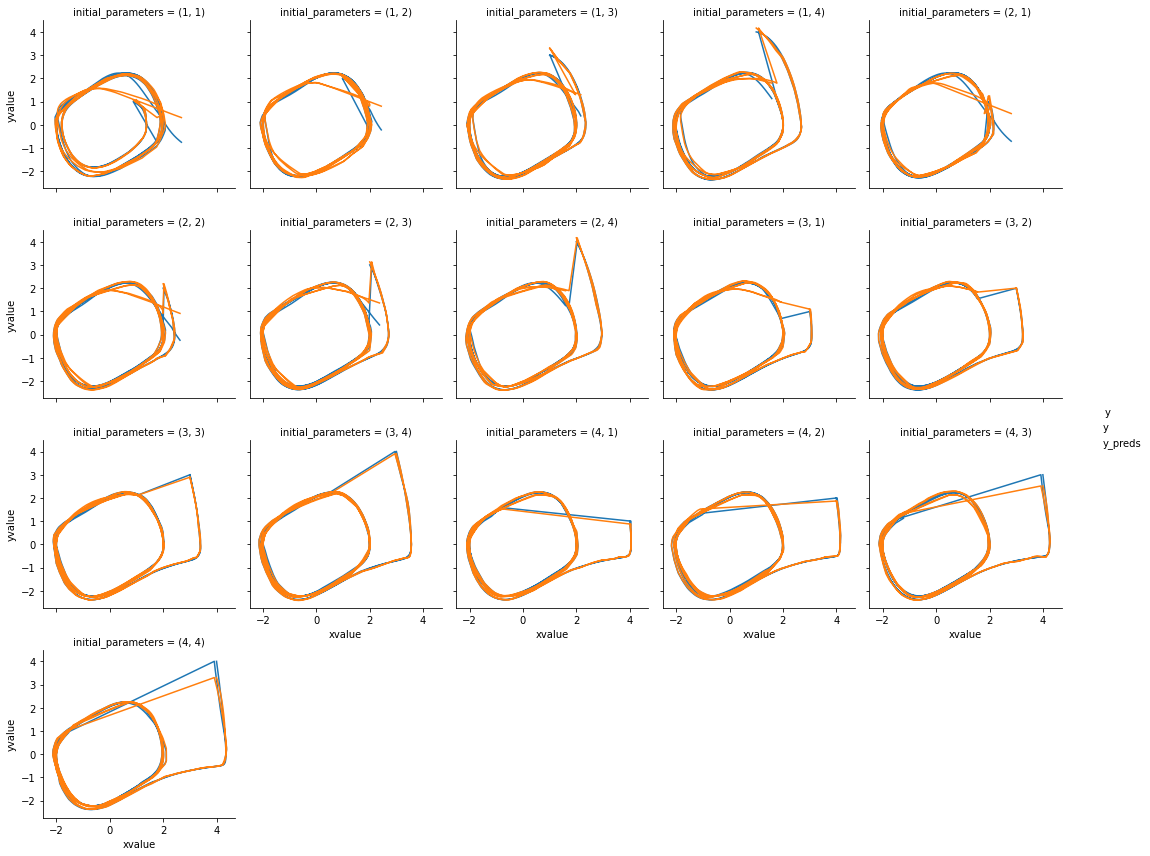

In [37]:
g = sns.FacetGrid(hue(training_and_predictions, ["x", "y"]), col="initial_parameters", hue="y", col_wrap=5,)
g.map(plot, "xvalue", "yvalue", ci=None)
g.add_legend()

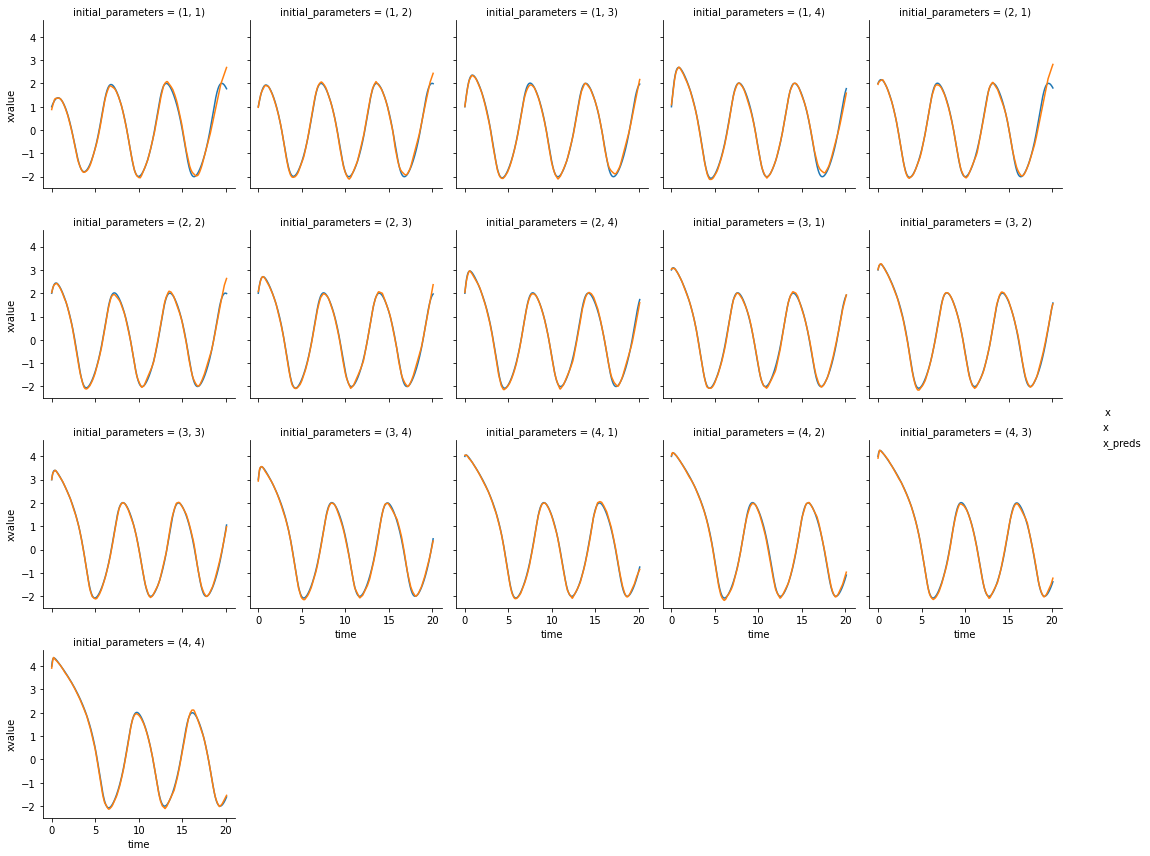

In [18]:
g = sns.FacetGrid(hue(training_and_predictions, ["x"]), col="initial_parameters", hue="x", col_wrap=5,)
g.map(plot, "time", "xvalue", ci=None)
g.add_legend()

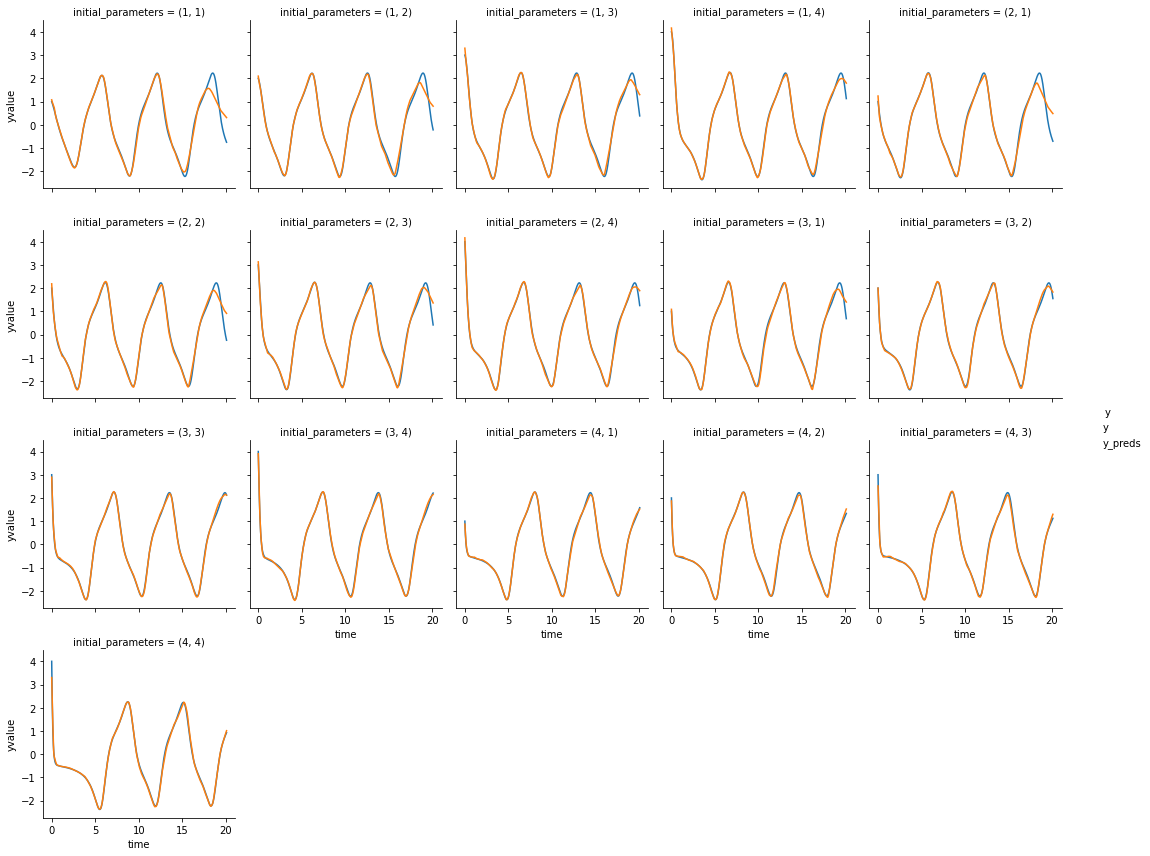

In [19]:
g = sns.FacetGrid(hue(training_and_predictions, ["y"]), col="initial_parameters", hue="y", col_wrap=5,)
g.map(plot, "time", "yvalue", ci=None)
g.add_legend()

## Testing : Simulations

This is produces simulations which will now be used as testing data. Where we have initial parameters in set [5,6]

In [35]:
testing = van_der_pol_oscillator(delta = 0.001, simulations = 20.1, save = False, initial_paras = np.round(np.random.uniform(0, 5, 8), 2))

This puts the inital parameters columns into one column as tuple

In [36]:
testing["initial_parameters"] = list(zip(testing.initial_x, testing.initial_y))
testing.head()

,time,x,y,initial_x,initial_y,initial_parameters
0,0.000,4.370000,4.370000,4.37,4.37,"(4.37, 4.37)"
1,0.001,4.374348,4.326243,4.37,4.37,"(4.37, 4.37)"
2,0.002,4.378653,4.282795,4.37,4.37,"(4.37, 4.37)"
3,0.003,4.382914,4.239656,4.37,4.37,"(4.37, 4.37)"
4,0.004,4.387132,4.196825,4.37,4.37,"(4.37, 4.37)"


In [37]:
len(testing)

1286400

## Testing : Predictions

This will be used for getting the predictions of the testing data

In [38]:
def testing_preds(test_df):
    inputs = torch.tensor(test_df.iloc[ :, [0,3,4]].values)
    targets = torch.tensor(test_df.iloc[:, [1,2]].values)
    preds, _ = predictions(num_inputs=3, num_classes=2, learning_rate=0.0005, batch_size=1, num_epochs=1, inputs=inputs.float(), targets=targets.float(), train=False, path= "../../data/state/van.pth")
    data = {'time' : test_df.time.values,
            'initial_parameters' : test_df.initial_parameters.values,
            'x' : tensor_flatten(preds[:,0]), 'y' : tensor_flatten(preds[:, 1])}
    return pd.DataFrame(data = data, columns = ["time", "x", "y", "initial_parameters"]);

In [39]:
testing_preds = testing_preds(testing)

In [40]:
len(testing_preds)

1286400

In [41]:
testing_preds.head()

,time,x,y,initial_parameters
0,0.000,4.165021,3.490379,"(4.37, 4.37)"
1,0.001,4.167245,3.478673,"(4.37, 4.37)"
2,0.002,4.169470,3.466967,"(4.37, 4.37)"
3,0.003,4.171700,3.455256,"(4.37, 4.37)"
4,0.004,4.173927,3.443547,"(4.37, 4.37)"


This is manipulating the dataframes, for it to be later used in plotting graphs

In [42]:
testing_preds = testing_preds.rename(columns={"x" : "x_preds", "y" : "y_preds"})

In [43]:
testing_and_predictions = pd.merge(testing, testing_preds, right_on=["time", "initial_parameters"], left_on=["time", "initial_parameters"])

In [44]:
testing_and_predictions.head()

,time,x,y,initial_x,initial_y,initial_parameters,x_preds,y_preds
0,0.000,4.370000,4.370000,4.37,4.37,"(4.37, 4.37)",4.165021,3.490379
1,0.001,4.374348,4.326243,4.37,4.37,"(4.37, 4.37)",4.167245,3.478673
2,0.002,4.378653,4.282795,4.37,4.37,"(4.37, 4.37)",4.169470,3.466967
3,0.003,4.382914,4.239656,4.37,4.37,"(4.37, 4.37)",4.171700,3.455256
4,0.004,4.387132,4.196825,4.37,4.37,"(4.37, 4.37)",4.173927,3.443547


## Graphs

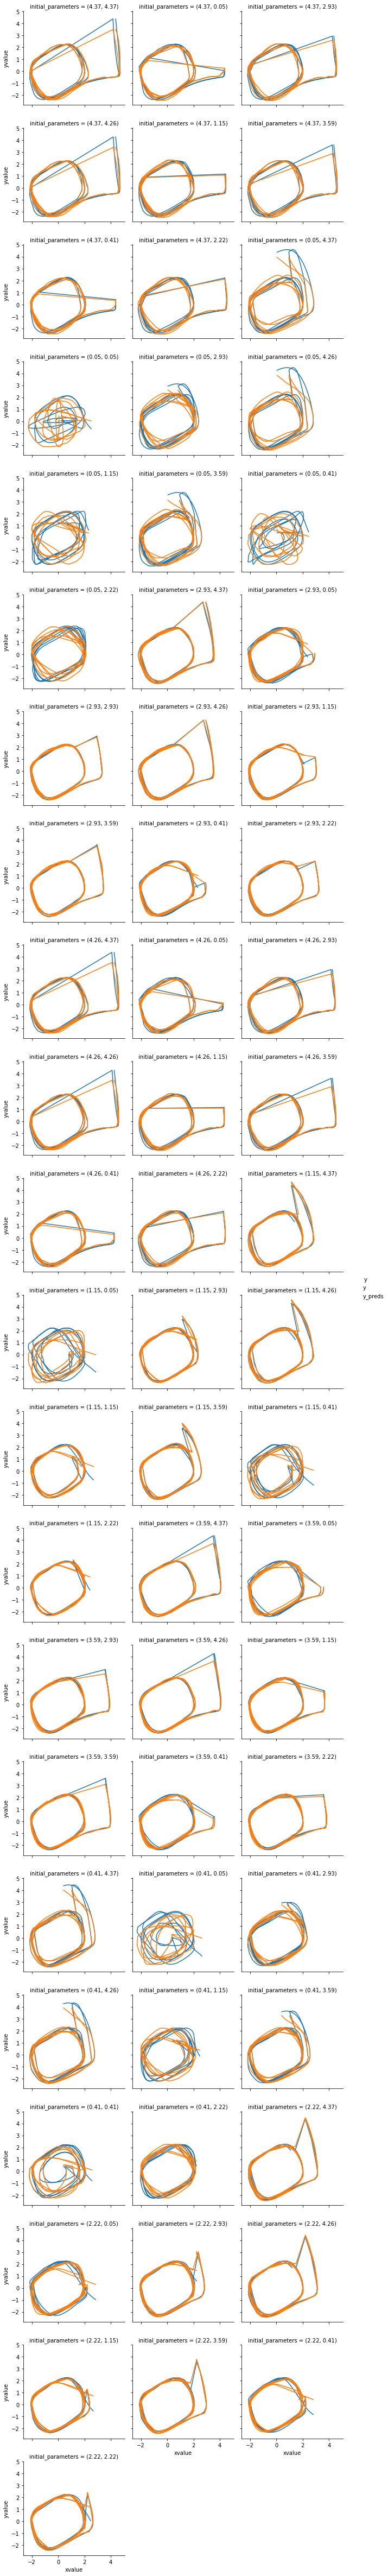

In [116]:
g = sns.FacetGrid(hue(testing_and_predictions, ["x", "y"]), col_wrap=3, col="initial_parameters", hue="y")
g.map(plot, "xvalue", "yvalue", ci=None)
g.add_legend()

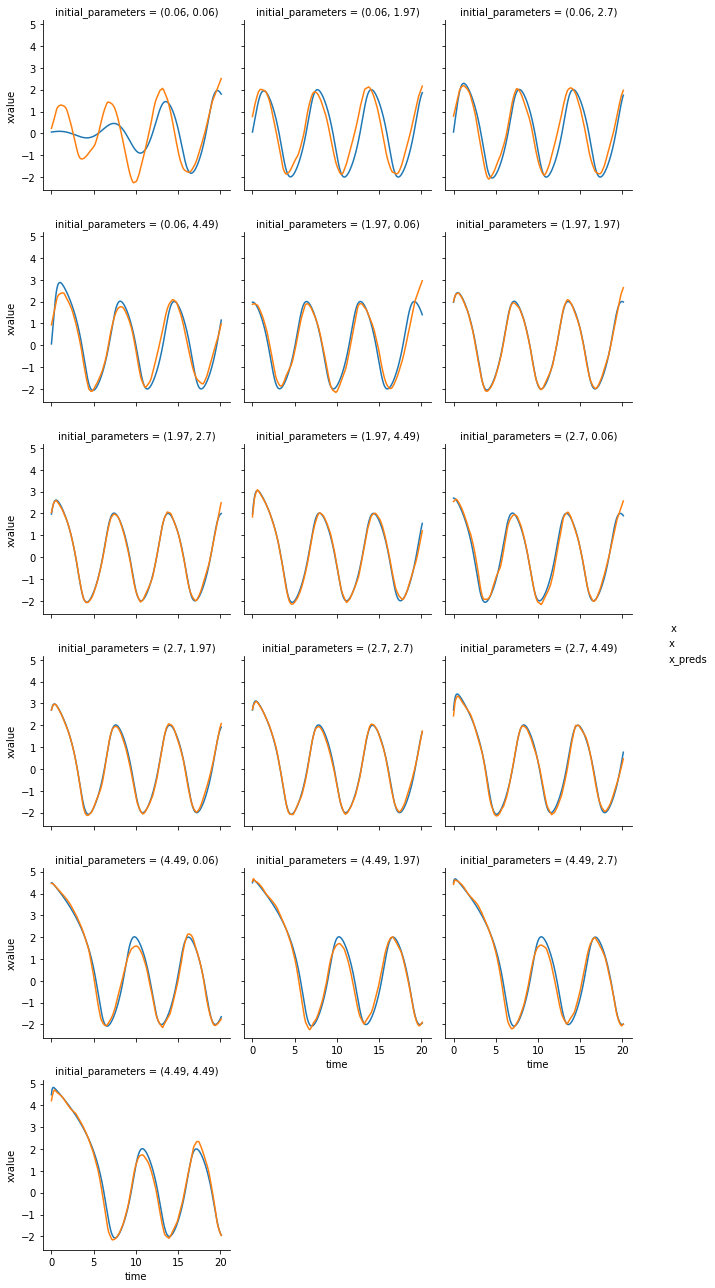

In [28]:
g = sns.FacetGrid(hue(testing_and_predictions, ["x"]), col_wrap=3, col="initial_parameters", hue="x",)
g.map(plot, "time", "xvalue", ci=None)
g.add_legend()

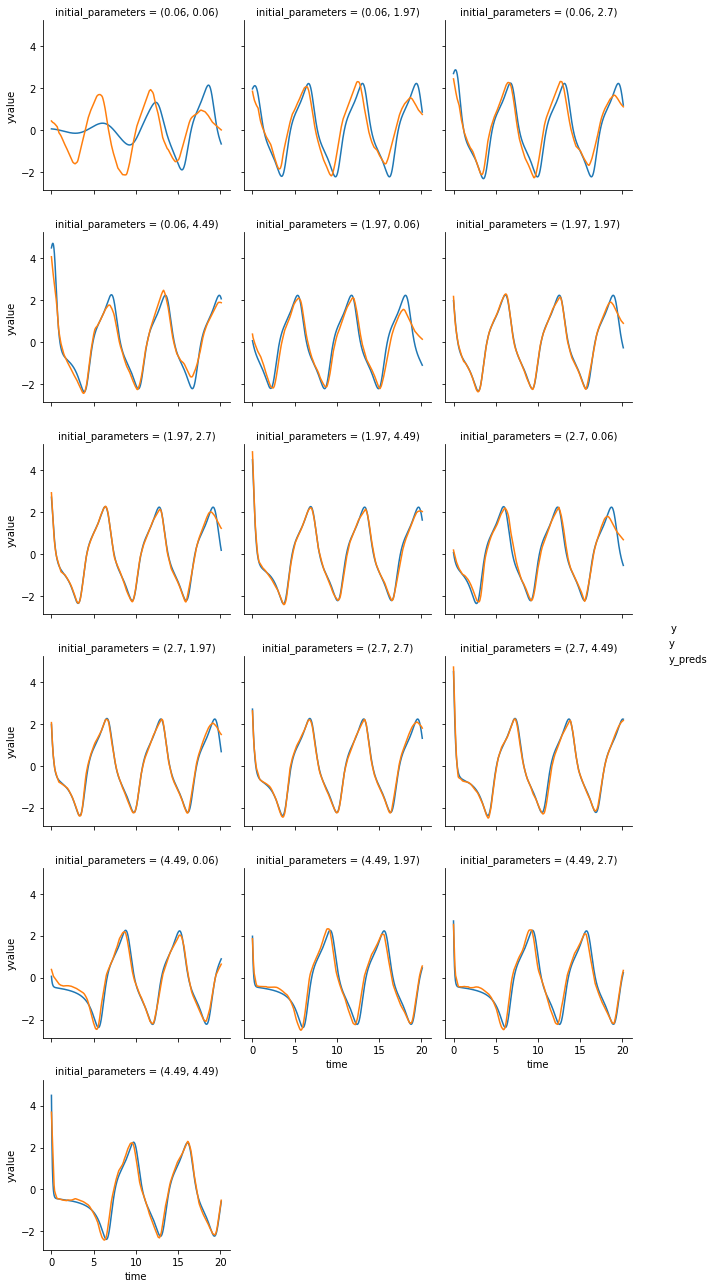

In [29]:
g = sns.FacetGrid(hue(testing_and_predictions, ["y"]), col_wrap=3, col="initial_parameters", hue="y")
g.map(plot, "time", "yvalue", ci=None)
g.add_legend()

### Loss my simulations

This is section is demonstrating how the loss changes for a certain individual.

Below is the dataframes we are using:
    <ol>
    <li> testing - the simulations testing data </li>
    <li> testing_predictions - the predictions of the simulation testing data </li>
    </ol>

In [45]:
testing.head()

,time,x,y,initial_x,initial_y,initial_parameters
0,0.000,4.370000,4.370000,4.37,4.37,"(4.37, 4.37)"
1,0.001,4.374348,4.326243,4.37,4.37,"(4.37, 4.37)"
2,0.002,4.378653,4.282795,4.37,4.37,"(4.37, 4.37)"
3,0.003,4.382914,4.239656,4.37,4.37,"(4.37, 4.37)"
4,0.004,4.387132,4.196825,4.37,4.37,"(4.37, 4.37)"


In [46]:
testing_preds.head()

,time,x_preds,y_preds,initial_parameters
0,0.000,4.165021,3.490379,"(4.37, 4.37)"
1,0.001,4.167245,3.478673,"(4.37, 4.37)"
2,0.002,4.169470,3.466967,"(4.37, 4.37)"
3,0.003,4.171700,3.455256,"(4.37, 4.37)"
4,0.004,4.173927,3.443547,"(4.37, 4.37)"


This is the lossBySimulation function. This provides us with the loss for each simulatin

In [47]:
simulationLoss, _ = lossBySimulations(testing, testing_preds, [1,2])

This is the simulationLoss dataframe, showing the inital parameters (simulation) and the corresponding loss

In [48]:
simulationLoss.head()

,initial_parameters,Loss
0,0.05 0.05,0.717932
1,0.05 0.41,1.099945
2,0.05 1.15,0.653796
3,0.05 2.22,0.301363
4,0.05 2.93,0.194808


In [49]:
len(simulationLoss)

64

In [50]:
simulationLossDistance = lossBySimulationsDistance(simulationLoss, initial_values = [np.arange(1,5,1),np.arange(1,5,1)])

In [51]:
simulationLossDistance.head()

,initial_parameters,Loss,Distance
27,2.22 2.22,0.015568,0.342929
28,2.22 2.93,0.009076,0.444382
35,2.93 2.22,0.003596,0.444382
36,2.93 2.93,0.002819,0.526640
43,3.59 2.22,0.006190,0.974615


This is a bar box plot of that simulation

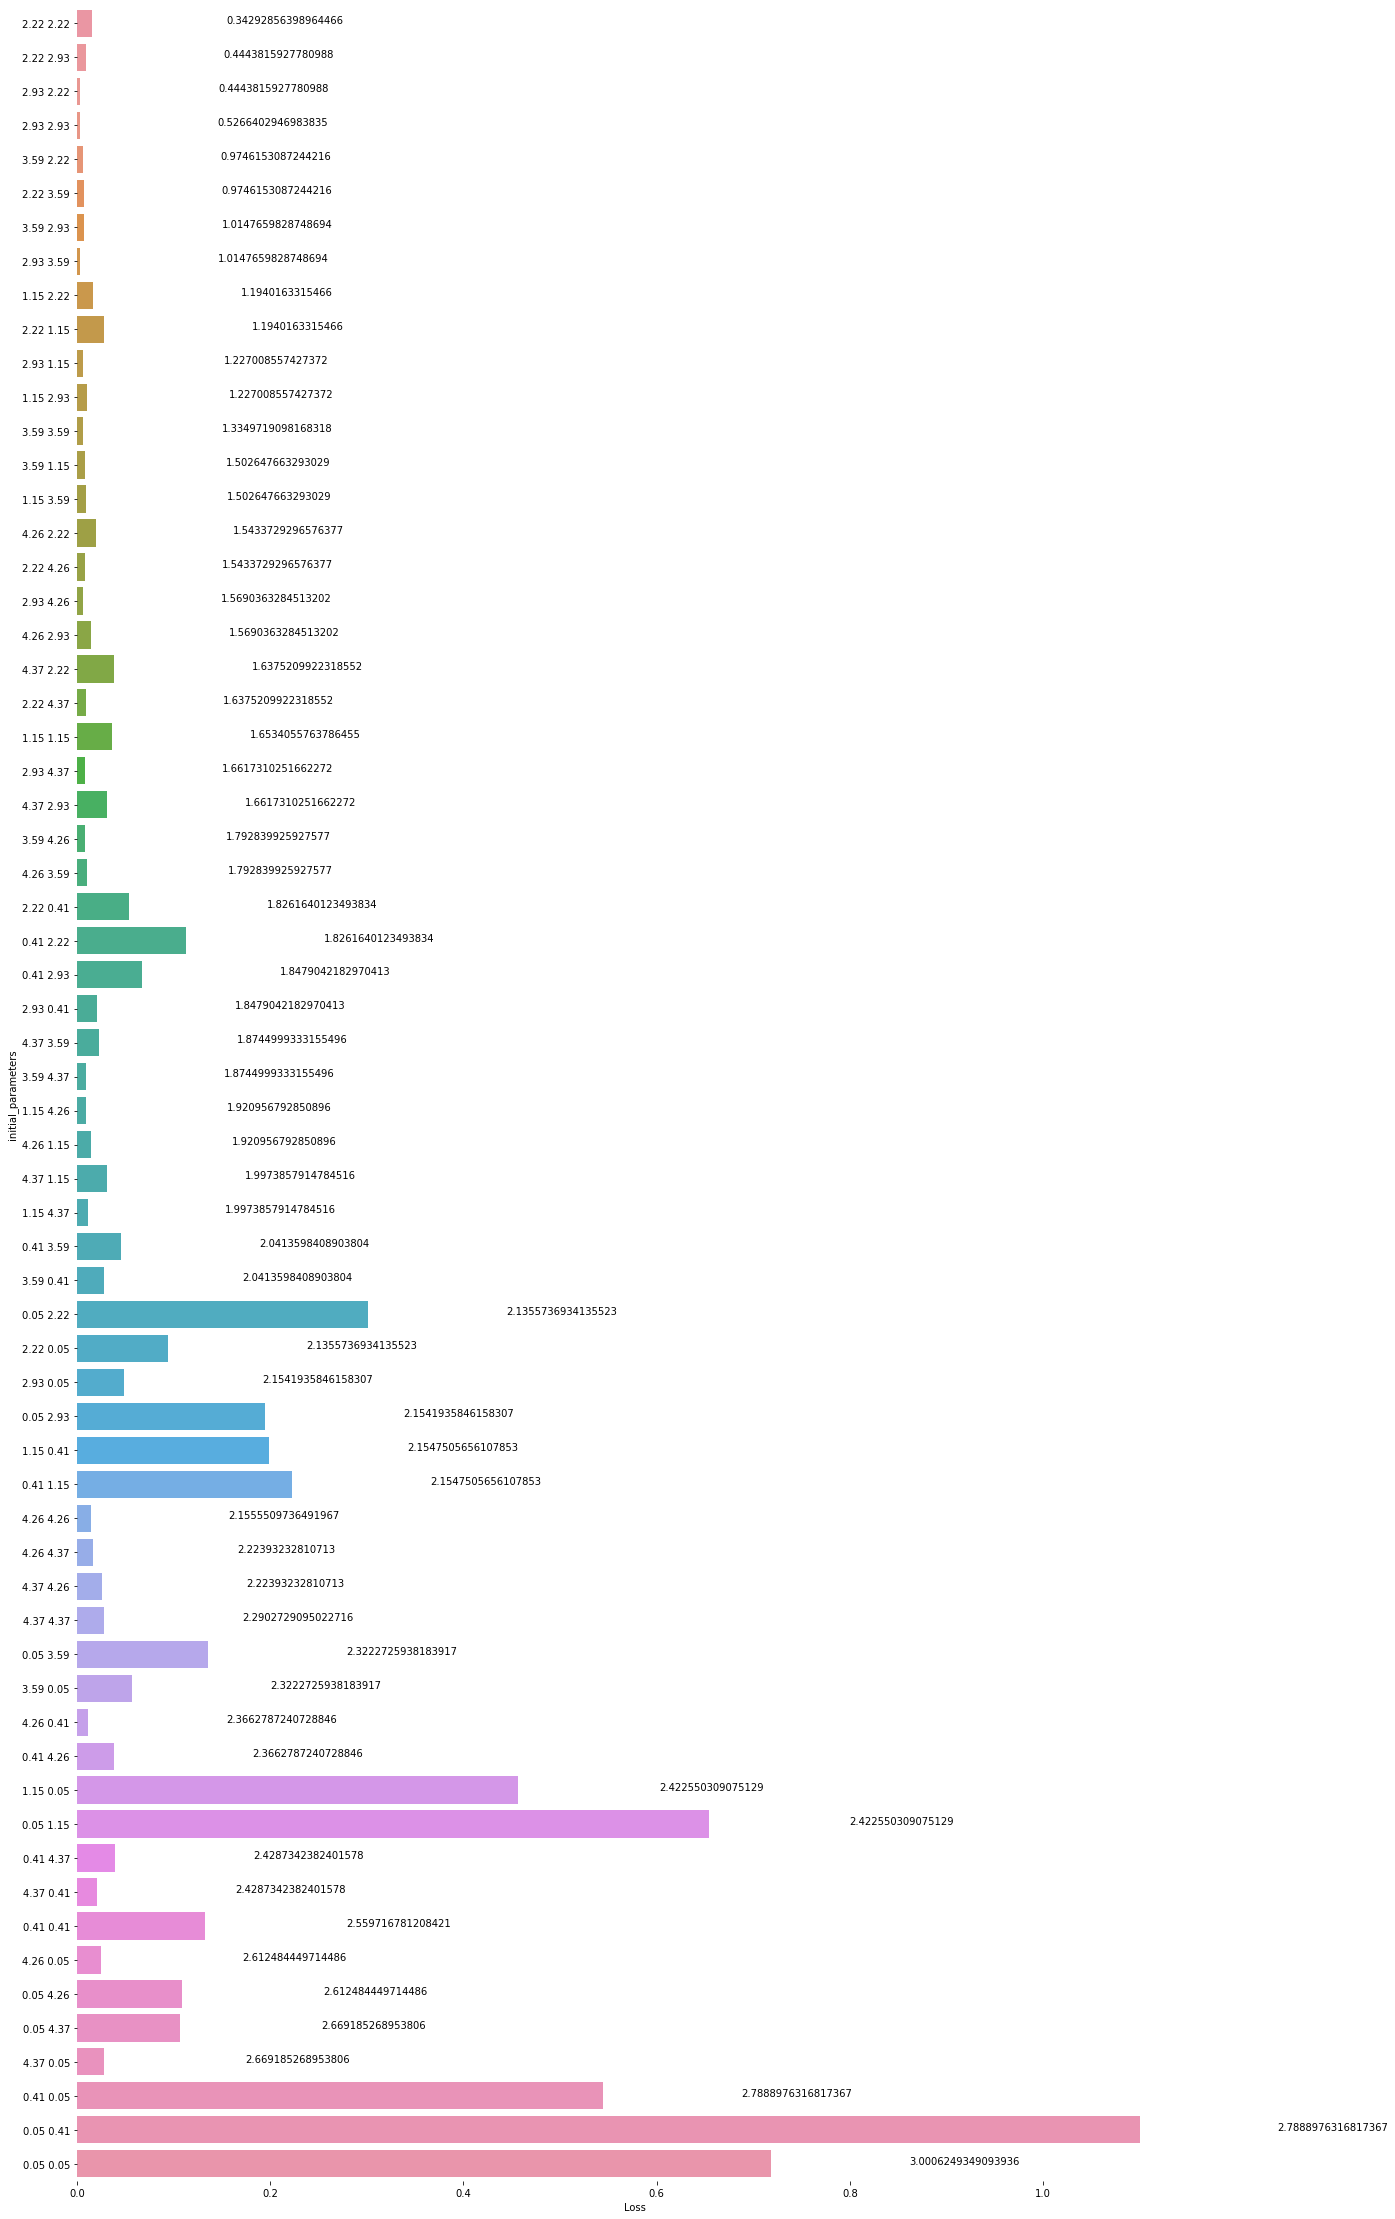

In [64]:
simulaPlots("Loss", "initial_parameters", simulationLossDistance, figsize = (20,40), pos = 0.2)

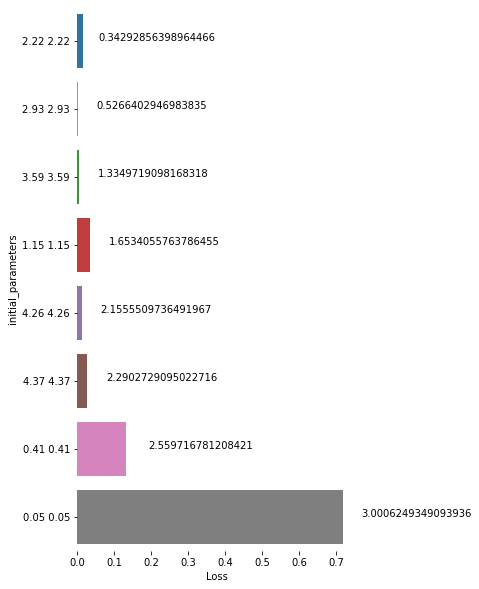

In [135]:
simulaPlots("Loss", "initial_parameters", simulationLossDistance.groupby("Distance").filter(lambda x: len(x) == 1), figsize = (5,10), pos = 0.2)

<AxesSubplot:>

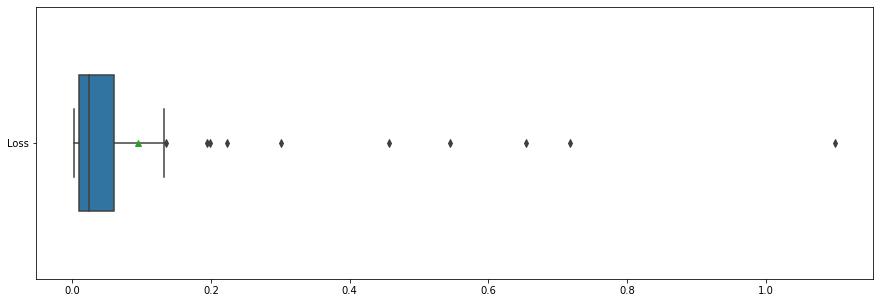

In [124]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data = simulationLossDistance[["Loss"]], showmeans=True, orient="h", width = 0.5, ax=ax)

In [103]:
simulationSameDistance = simulationLossDistance.groupby("Distance").filter(lambda x: len(x) > 1)
simulationAverage = simulationSameDistance.groupby("Distance").mean("Loss").reset_index()
simulationMin = simulationSameDistance.groupby("Distance").min("Loss").reset_index()
simulationMax = simulationSameDistance.groupby("Distance").max("Loss").reset_index()

In [104]:
simulationAverage.head()

,Distance,Loss
0,0.444382,0.006336
1,0.974615,0.006554
2,1.014766,0.005350
3,1.194016,0.022397
4,1.227009,0.008501


In [105]:
simulationMin.head()

,Distance,Loss
0,0.444382,0.003596
1,0.974615,0.006190
2,1.014766,0.003124
3,1.194016,0.016707
4,1.227009,0.006169


In [106]:
simulationMax.head()

,Distance,Loss
0,0.444382,0.009076
1,0.974615,0.006919
2,1.014766,0.007576
3,1.194016,0.028087
4,1.227009,0.010834


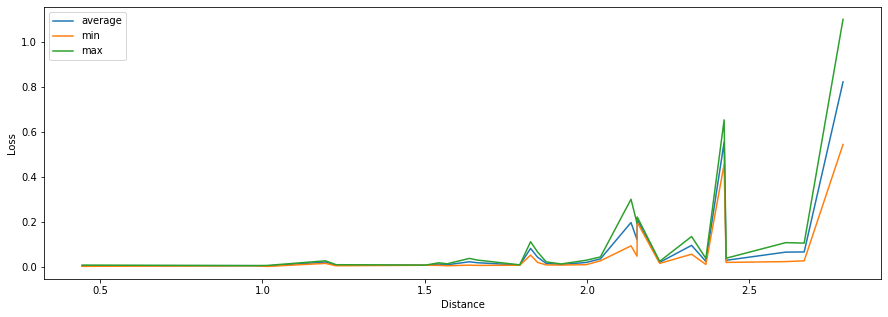

In [122]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data = simulationAverage, x = "Distance", y = "Loss", ax = ax, label = "average")
sns.lineplot(data = simulationMin, x = "Distance", y = "Loss", ax = ax, label = "min")
sns.lineplot(data = simulationMax, x = "Distance", y = "Loss", ax = ax, label = "max")
ax.legend()

The lossByTime function would provide a loss for a specfic time for a certain simulation

In [111]:
timeLoss, _ = lossByTime(testing, testing_preds, [1,2])

The timeLoss now holds the loss corresponding to a specific time for a intial_parameter (simulation). This is demonstrated below

In [112]:
timeLoss.head()

,Time,initial_parameters,Loss
0,0.000,"(0.05, 0.05)",0.088112
1,0.001,"(0.05, 0.05)",0.088156
2,0.002,"(0.05, 0.05)",0.088202
3,0.003,"(0.05, 0.05)",0.088249
4,0.004,"(0.05, 0.05)",0.088300


In [113]:
individualTimeLoss = timeLoss.groupby("Time").mean("Loss").reset_index()

In [114]:
individualTimeLoss

,Time,Loss
0,0.000,0.108747
1,0.001,0.106029
2,0.002,0.103437
3,0.003,0.100967
4,0.004,0.098617
...,...,...
20095,20.095,0.322033
20096,20.096,0.322870
20097,20.097,0.323709
20098,20.098,0.324551


The graphs showning these plots

<AxesSubplot:xlabel='Time', ylabel='Loss'>

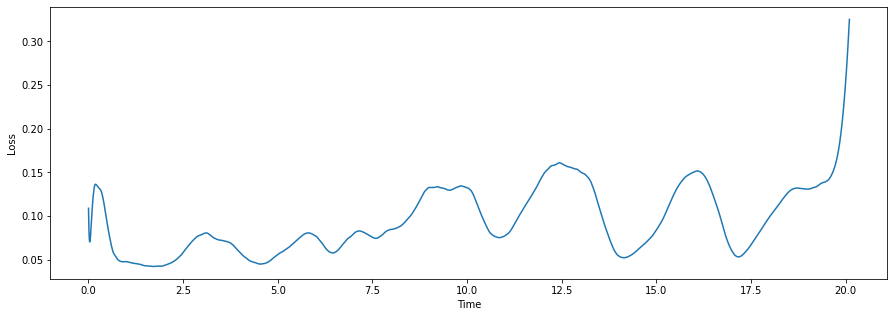

In [123]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data = individualTimeLoss, x = "Time", y = "Loss", ax = ax)